### Setup

In [2]:
import os, sys
HOME = os.environ['HOME']  # change if necessary
sys.path.append(f'{HOME}/Finite-groups/src')

In [3]:
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
from jaxtyping import Float
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
import pandas as pd
from typing import Union
from einops import repeat
from huggingface_hub import snapshot_download
from huggingface_hub.utils import disable_progress_bars


from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
%load_ext autoreload
%autoreload 2

Syntax warning: Unbound global variable in /usr/share/gap/pkg/browse/PackageIn\
fo.g:73
  if not IsKernelExtensionAvailable("Browse", "ncurses") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
Syntax warning: Unbound global variable in /usr/share/gap/pkg/edim/PackageInfo\
.g:60
  if not IsKernelExtensionAvailable("EDIM","ediv") then
         ^^^^^^^^^^^^^^^^^^^^^^^^^^


In [80]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
# MODEL_DIR = '2024-08-16_22-53-29_SL2_5_MLP3_256'
# MODEL_DIR = '2024-08-14_21-24-30_gapS_5_'
# MODEL_DIR = '2024-09-18_23-59-00_gapS5_MLP2_128_wd2e-4_ubias'
# MODEL_DIR = '2024-09-22_22-12-21_gapF11_MLP2_256_wd1e-4_ubias'
MODEL_DIR = '2024-09-23_01-06-18_A5x2_MLP2_128_wd1e-4_ubias'
# MODEL_DIR = '2024-09-18_03-03-59_gapS5_MLP2_64_wd2e-4_ubias_train1_0'
# MODEL_DIR = '2024-09-18_03-21-55_gapS5_MLP2_64_wd2e-4_ubias_train1_0'
# MODEL_DIR = '2024-09-17_21-48-39_gapS5_MLP3_128_wd2e-4_betafix'
# MODEL_DIkR = '2024-09-17_05-20-44_gapS5_MLP3_128_wd2e-4'
# MODEL_DIR = '2024-09-16_05-00-33_gapS5_MLP2_128_adamw_wd1'
# MODEL_DIR = '2024-08-27_16-32-46_Dic30_MLP3_128'
# MODEL_DIR = '2024-08-27_23-16-05_F11_MLP3_256'
# MODEL_DIR = '2024-09-02_18-17-20_smallgrp_54_8_MLP3_256_0_6'
# MODEL_DIR = '2024-09-05_15-22-58_smallgrp_54_8_MLP3_1024_0_6'
# MODEL_DIR = '2024-09-05_20-47-44_smallgrp_54_8_MLP3_1024_0_6_wd1e-6'
# MODEL_DIR = '2024-09-02_18-51-29_smallgrp_96_71_MLP3_256_0_6'
# MODEL_DIR = '2024-09-03_17-28-20_smallgrp_192_1025_MLP3_512_0_6'
# MODEL_DIR = '2024-09-03_21-09-07_Z_59_128'
disable_progress_bars()
local_dir = f'{HOME}/models/{MODEL_DIR}'
if not os.path.exists(local_dir):
    snapshot_download(repo_id=f'wiwu2390/{MODEL_DIR}', local_dir=local_dir)
models, params = load_models(local_dir, sel='final')
data = GroupData(params)
group = data.groups[0]

Intersection size: 14400/14400 (1.00)
Added 14400 elements from intersection
Added 0 elements from group 0: smallgrp(120,35)
Taking random subset: 5760/14400 (0.40)
Train set size: 5760/14400 (0.40)


/home/wilson/Finite-groups/src/model_utils.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load(model_path, map_location=device))


`models` (returned from `load_models`) is a list of InstancedModule objects, one for each training checkpoint that we chose to save. For most runs, we only save the final checkpoints, so `len(models)==1`

For efficiency during training, the InstancedModule object contains 100 different instances starting from different random initializations. 

Here, we look only at the one with best test accuracy.

In [81]:
loss_dict = test_loss(models[0].to(device), data)

In [82]:
# instance = loss_dict['G0_acc'].argmax().item()
instance = loss_dict['G0_loss'].argmin().item()
# instance = (loss_dict['G0_acc'] > 0.999).nonzero()[11]
# instance = 33
print(loss_dict[f'G0_loss'][instance], loss_dict[f'G0_acc'][instance], instance)
model = models[-1][instance].to(device)
# print(model.embedding_left.norm() + model.embedding_right.norm() + model.linear.norm() + model.unembedding.norm())

tensor(0.0156) tensor(1.) 42


`MLP3` architecture is
$$f(z\mid x, y) = W_u(z)\cdot\text{ReLU}[W_h(W_l(x)+W_r(y))]] = \sum_i w_u^i(z) \text{ReLU}[w_l^i(x)+w_r^i(y)]$$
where $w_u^i, w_l^i, w_r^i\in\mathbb{R}^G$ are the columns of $W_u, (W_hW_l)^{\top}, (W_hW_r)^{\top}$ respectively.

In [83]:
COMPLEX = False

# model.get_neurons() folds the linear map into the embeddings
lneurons, rneurons, uneurons = model.get_neurons(squeeze=True)
if COMPLEX:
    lneurons = t.complex(lneurons, t.zeros_like(lneurons))
    rneurons = t.complex(rneurons, t.zeros_like(rneurons))
    uneurons = t.complex(uneurons, t.zeros_like(uneurons))
# lneurons = t.complex(t.zeros_like(lneurons), lneurons)
# rneurons = t.complex(t.zeros_like(rneurons), rneurons)
# uneurons = t.complex(t.zeros_like(uneurons), uneurons)
lneurons.shape, rneurons.shape, uneurons.shape

(torch.Size([120, 128]), torch.Size([120, 128]), torch.Size([120, 128]))

In [84]:
def ablate_loss(ln, rn, un):
    ablate_model = copy.deepcopy(model)
    if not isinstance(ablate_model, MLP4):
        ablate_model = ablate_model.fold_linear()
    ablate_model.embedding_left.data = ln.unsqueeze(0)
    ablate_model.embedding_right.data = rn.unsqueeze(0)
    ablate_model.unembedding.data = un.unsqueeze(0).mT
    return test_loss(ablate_model.to(device), data)

def ablate_idx_loss(idxs):
    ln, rn= model.get_neurons()
    un = model.unembedding.data.detach()
    ln, rn, un = ln.squeeze(0).to('cpu'), rn.squeeze(0).to('cpu'), un.squeeze(0).to('cpu').T
    ln, rn, un = ln[:, idxs], rn[:, idxs], un[:, idxs]
    return ablate_loss(ln, rn, un)

### Neurons are irrep-sparse

I.e., each neuron is a linear combination of matrix entries of some irrep.

That is, for each $i$, there exists an irrep $\rho_i\colon G\to\text{GL}(\mathbb{R}^d)$ such that, for some $A_i,B_i,C_i$,
$$w_l^i(x) \approx \text{tr}(\rho_i(x) A_i)$$
$$w_r^i(y) \approx \text{tr}(\rho_i(y) B_i)$$
$$w_u^i(z) \approx \text{tr}(\rho_i(z) C_i)$$

(This was first noticed by Chughtai et al.)

**Notation**: 4d-0 is the 1st degree 4 irrep, 4d-1 is the 2nd, etc. Ordering is arbitrary but is consistent between runs (I think)

In [85]:
if COMPLEX:
    irreps = group.get_complex_irreps()
else:
    irreps = group.get_real_irreps(verbose=True)
print(irreps.keys())

dict_keys(['1d-0', '1d-1', '3d-0', '3d-1', '3d-2', '3d-3', '4d-0', '4d-1', '5d-0', '5d-1'])


In [86]:
# Get orthogonal basis for each irrep
irrep_bases = dict()
for name, irrep in irreps.items():
    irrep = einops.rearrange(irrep, 'N d1 d2 -> N (d1 d2)')
    U, S, V = t.svd(irrep)
    nonzero = S > 1e-5
    irrep_bases[name] = U[:,nonzero]

# Dimension of subspace spanned by each irrep
for k, v in irrep_bases.items():
    print(k, v.shape)

1d-0 torch.Size([120, 1])
1d-1 torch.Size([120, 1])
3d-0 torch.Size([120, 9])
3d-1 torch.Size([120, 9])
3d-2 torch.Size([120, 9])
3d-3 torch.Size([120, 9])
4d-0 torch.Size([120, 16])
4d-1 torch.Size([120, 16])
5d-0 torch.Size([120, 25])
5d-1 torch.Size([120, 25])


In [87]:
# Proportion of variance explained by each irrep, for each neuron
lexpl, rexpl, uexpl = dict(), dict(), dict()

for name, basis in irrep_bases.items():
    lexpl[name] = (basis.H @ lneurons).norm(dim=0)**2 / (lneurons.norm(dim=0)**2 + 1e-8)
    rexpl[name] = (basis.H @ rneurons).norm(dim=0)**2 / (rneurons.norm(dim=0)**2 + 1e-8)
    uexpl[name] = (basis.H @ uneurons).norm(dim=0)**2 / (uneurons.norm(dim=0)**2 + 1e-8)

lexpl_max, lirrep = t.stack(list(lexpl.values()), dim=0).max(dim=0)
rexpl_max, rirrep = t.stack(list(rexpl.values()), dim=0).max(dim=0)
uexpl_max, uirrep = t.stack(list(uexpl.values()), dim=0).max(dim=0)

to_P = lambda basis: basis @ basis.H

ln_proj = t.stack([to_P(list(irrep_bases.values())[lirrep[i]]) @ lneurons[:,[i]] for i in range(lneurons.shape[1])], dim=1).squeeze(-1)
rn_proj = t.stack([to_P(list(irrep_bases.values())[rirrep[i]]) @ rneurons[:,[i]] for i in range(rneurons.shape[1])], dim=1).squeeze(-1)
un_proj = t.stack([to_P(list(irrep_bases.values())[uirrep[i]]) @ uneurons[:,[i]] for i in range(uneurons.shape[1])], dim=1).squeeze(-1)

In [88]:
basis = irrep_bases['4d-1']
P = basis @ basis.T
ablate_loss(lneurons, rneurons, uneurons), ablate_loss(ln_proj, rn_proj, uneurons), ablate_loss(lneurons, rneurons, un_proj), ablate_loss(ln_proj, rn_proj, un_proj)

({'G0_loss': tensor([0.0156]), 'G0_acc': tensor([1.])},
 {'G0_loss': tensor([0.0156]), 'G0_acc': tensor([1.])},
 {'G0_loss': tensor([0.0195]), 'G0_acc': tensor([1.])},
 {'G0_loss': tensor([0.0194]), 'G0_acc': tensor([1.])})

In [89]:
# ures_expl = dict()
ubias = model.unembed_bias.data.squeeze(0)
ubias_expl = dict()
for name, basis in irrep_bases.items():
    # ures_expl[name] = (basis.H @ ures).norm(dim=0)**2 / (ures.norm(dim=0)**2 + 1e-8)
    ubias_expl[name] = (basis.H @ ubias).norm(dim=0)**2 / (ubias.norm(dim=0)**2 + 1e-8)
ubias_expl

{'1d-0': tensor(0.0113),
 '1d-1': tensor(0.9302),
 '3d-0': tensor(0.0101),
 '3d-1': tensor(0.0395),
 '3d-2': tensor(0.0001),
 '3d-3': tensor(0.0002),
 '4d-0': tensor(0.0017),
 '4d-1': tensor(0.0004),
 '5d-0': tensor(0.0060),
 '5d-1': tensor(0.0004)}

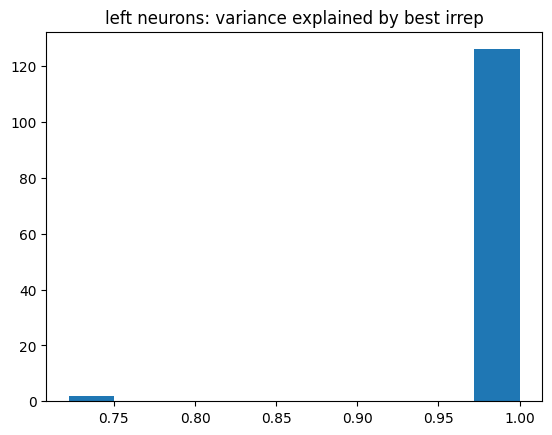

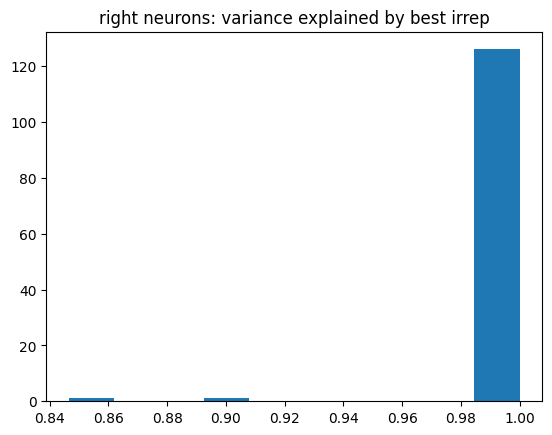

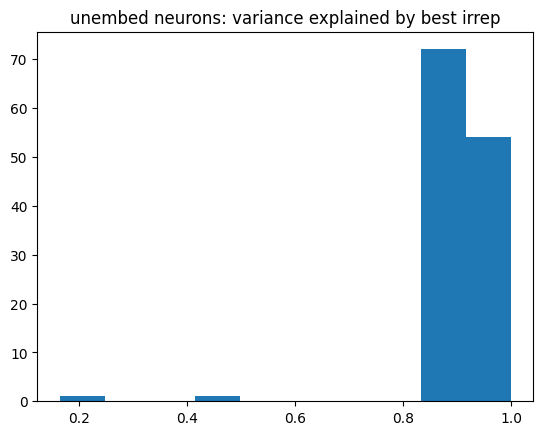

In [90]:
for name, expl in [('left', lexpl_max), ('right', rexpl_max), ('unembed', uexpl_max)]:
    plt.hist(expl.tolist())
    plt.title(f'{name} neurons: variance explained by best irrep')
    plt.show()

In [91]:
uexpl_max

tensor([0.8995, 0.9966, 0.8827, 0.8718, 0.9829, 0.8572, 0.9966, 0.9976, 0.8929,
        0.9801, 0.8829, 0.8980, 0.8740, 0.8753, 0.9868, 0.8605, 0.8807, 0.8512,
        0.9970, 0.1641, 0.8530, 0.9837, 0.8396, 0.8631, 0.8885, 0.8889, 0.9903,
        0.8564, 0.9849, 0.8724, 0.8696, 0.8915, 0.8539, 0.9870, 0.8659, 0.9852,
        0.8498, 0.9989, 0.9856, 0.9976, 0.8412, 0.8937, 0.9973, 0.9972, 0.9865,
        0.9872, 0.9875, 0.9973, 0.8374, 0.9974, 0.8749, 0.9990, 0.9965, 0.9887,
        0.8794, 0.9966, 0.9831, 0.8702, 0.8688, 0.9966, 0.8733, 0.9970, 0.9958,
        0.8873, 0.8475, 0.9980, 0.9881, 0.9849, 0.9974, 0.9860, 0.8741, 0.9848,
        0.9025, 0.8982, 0.8755, 0.9480, 0.9972, 0.8818, 0.8549, 0.8484, 0.8942,
        0.8554, 0.9879, 0.8555, 0.8464, 0.9972, 0.8691, 0.9000, 0.8656, 0.9973,
        0.8778, 0.8899, 0.9970, 0.9867, 0.8821, 0.8670, 0.9017, 0.9972, 0.4711,
        0.9897, 0.8466, 0.9865, 0.8943, 0.8761, 0.8806, 0.9969, 0.8691, 0.9972,
        0.9965, 0.8682, 0.8749, 0.9964, 

In [92]:
lexpl_max

tensor([0.9993, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.7221, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 0.9993, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9993, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9992, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9993, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9978, 1.0000, 0.7364,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [93]:
# Get Frobenius-Schur indicators
# +1 means real irrep. Otherwise, complex.
for name, irrep in irreps.items():
    print(name, group.get_frobenius_schur(irrep))

1d-0 1
1d-1 1
3d-0 1
3d-1 1
3d-2 1
3d-3 1
4d-0 1
4d-1 1
5d-0 1
5d-1 1


In [94]:
thresh = 0.95
norm_thresh = 1
irrep_idx_dict = {
    name: [
        i for i in range(lneurons.shape[-1]) 
        if lexpl[name][i].item() > thresh and lneurons[:,i].norm() > norm_thresh
    ]
    for name in irreps
}
irrep_idx_dict['none'] = [
    i for i in range(lneurons.shape[-1])
    if all(lexpl[name][i].item() <= thresh for name in irreps) or lneurons[:,i].norm() < norm_thresh 
]
for k, v in irrep_idx_dict.items():
    print(k, len(v))

1d-0 0
1d-1 3
3d-0 0
3d-1 73
3d-2 0
3d-3 0
4d-0 50
4d-1 0
5d-0 0
5d-1 0
none 2


1d-1


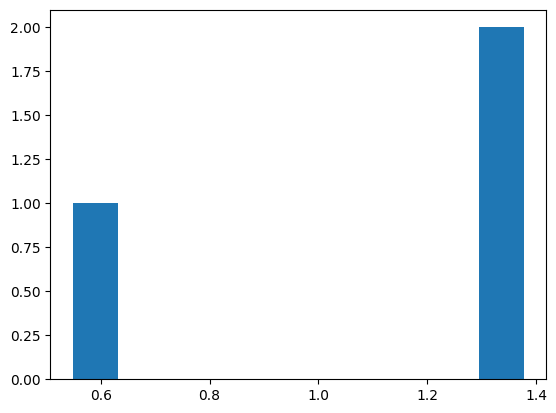

3d-1


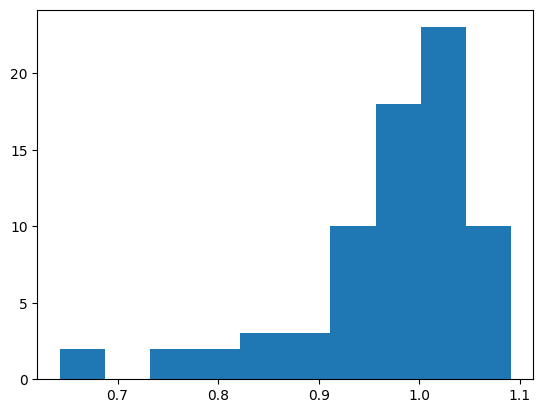

4d-0


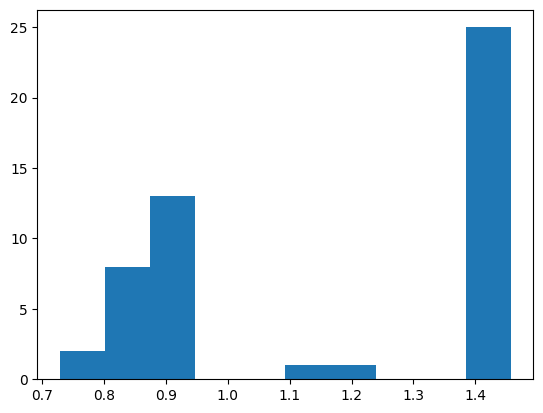

none


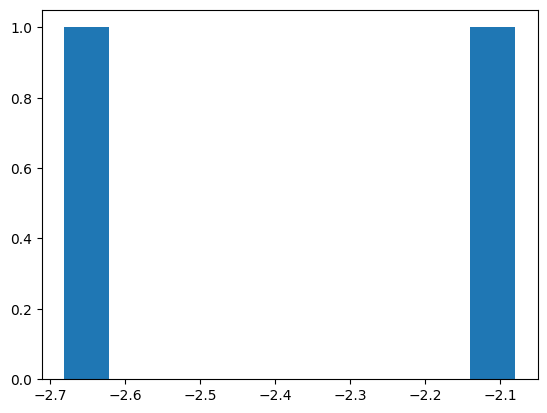

In [95]:
for k, v in irrep_idx_dict.items():
    if not v:
        continue
    print(k)
    plt.hist((lneurons[:,irrep_idx_dict[k]] + 1e-8).norm(dim=0).log10().tolist())
    plt.show()

In [96]:
irrep_name = '3d-1'
irrep_d = irreps[irrep_name].shape[-1]
irrep = irreps[irrep_name]
irrep_idxs = irrep_idx_dict[irrep_name]
irrep_lneurons = lneurons[:, irrep_idxs]
irrep_rneurons = rneurons[:, irrep_idxs]
irrep_uneurons = uneurons[:, irrep_idxs]
irrep_frobschur = np.sign(group.get_frobenius_schur(irrep)).item()

In [97]:
flat_irrep = einops.rearrange(irrep, 'n d1 d2 -> n (d1 d2)')
rcond = t.linalg.matrix_rank(flat_irrep)
# Project neurons onto subspace spanned by flat_irrep
A_flat = t.linalg.lstsq(flat_irrep, irrep_lneurons, driver='gelsd').solution
B_flat = t.linalg.lstsq(flat_irrep, irrep_rneurons, driver='gelsd').solution
C_flat = t.linalg.lstsq(flat_irrep, irrep_uneurons, driver='gelsd').solution
# A_flat = (t.linalg.inv(flat_irrep.H @ flat_irrep) @ flat_irrep.H @ irrep_lneurons)
# B_flat = (t.linalg.inv(flat_irrep.H @ flat_irrep) @ flat_irrep.H @ irrep_rneurons)
# C_flat = (t.linalg.inv(flat_irrep.H @ flat_irrep) @ flat_irrep.H @ irrep_uneurons)
A = einops.rearrange(A_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mH
B = einops.rearrange(B_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mH
C = einops.rearrange(C_flat, '(d1 d2) m -> m d1 d2', d1=irrep_d, d2=irrep_d).mH

A_norm = t.linalg.matrix_norm(A)
B_norm = t.linalg.matrix_norm(B)
print('A and B norm diff', ((A_norm - B_norm).norm()**2 / B_norm.norm()**2).item())

# Normalize A and B to have unit Frobenius norm
A = A / A_norm.unsqueeze(1).unsqueeze(1)
B = B / A_norm.unsqueeze(1).unsqueeze(1)
C = C * ( (A_norm + B_norm) / 2).unsqueeze(1).unsqueeze(1)

A.shape, B.shape, C.shape

A and B norm diff 4.784025804838166e-06


(torch.Size([73, 3, 3]), torch.Size([73, 3, 3]), torch.Size([73, 3, 3]))

### $C_i\approx B_iA_i$

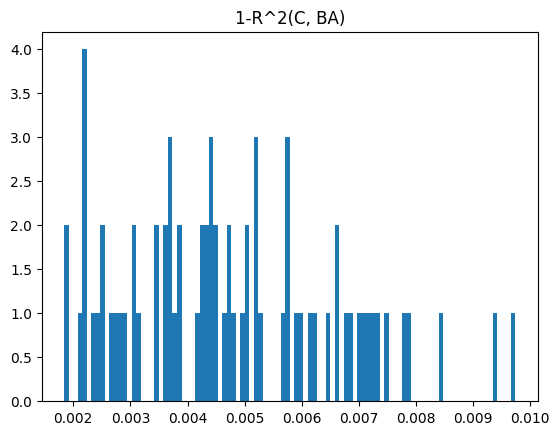

In [98]:
x = einops.rearrange(B @ A, 'm d1 d2 -> m (d1 d2)')
y = einops.rearrange(C, 'm d1 d2 -> m (d1 d2)')
coef = (x.conj() * y).sum(dim=-1) / (x.conj() * x).sum(dim=-1)
yhat = coef.unsqueeze(1) * x
r2 = (yhat - y).norm(dim=-1).pow(2) / y.norm(dim=-1).pow(2)
plt.hist(r2.tolist(), bins=100)
plt.title('1-R^2(C, BA)')
plt.show()
good = r2 < 0.3

# Restrict to good neurons
A, B, C, coef = A[good], B[good], C[good], coef[good]

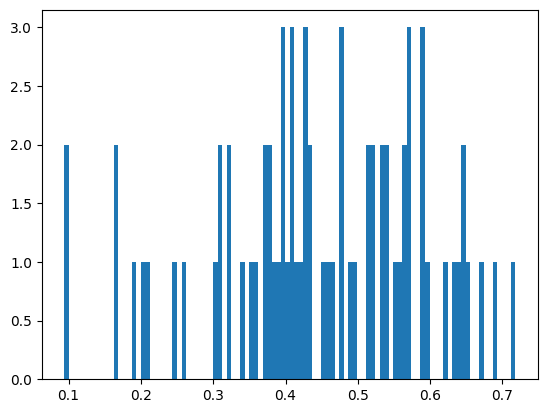

In [99]:
plt.hist(coef.tolist(), bins=100)
plt.show()

### $A_i, B_i, C_i$ are low rank

To be specific,
$$
\text{rank}(A)=\text{rank}(B)=\begin{cases}1 & \iota=1 \\ 2 & \iota=0 \\ 4 & \iota=-1,\end{cases}
$$
where $\iota$ is the Frobenius-Schur indicator. (+1 is real irrep, 0 is complex, and -1 is quaternionic.) 

In the real case, we can write
$$A_i\approx a_ib_i^\top$$
$$B_i\approx c_id_i^\top$$
$$C_i\approx A_iB_i\approx \langle b_i, c_i\rangle a_i d_i^\top$$

In [100]:
rank = {
    1: 1,
    0: 2,
    -1: 4
}[irrep_frobschur]

if irrep_frobschur == 1:
    a, b, c, d, Ss = [], [], [], [], []
    for i in range(A.shape[0]):
        lU, lS, lV = t.linalg.svd(A[i])
        rU, rS, rV = t.linalg.svd(B[i])
        Ss.append(lS[0])
        a.append(lU[:,0])
        b.append(lV[0])
        c.append(rU[:,0])
        d.append(rV[0])
        assert lS[0]**2 / lS.norm()**2 > 0.95, lS[0]**2 / lS.norm()**2
        assert rS[0]**2 / rS.norm()**2 > 0.95, rS[0]**2 / rS.norm()**2
    a, b, c, d = t.stack(a, dim=0), t.stack(b, dim=0), t.stack(c, dim=0), t.stack(d, dim=0)
    a_sign = t.sgn(a[:,0])
    a = t.diag(a_sign) @ a
    b = t.diag(a_sign) @ b
    d_sign = t.sgn(d[:,0])
    c = t.diag(d_sign) @ c
    d = t.diag(d_sign) @ d
    Ss = t.stack(Ss, dim=0)
else:
    # Our guess is that left singular vectors of A are const across neurons
    # and same for right singular vectors of B (up to sign, etc)
    # So we use the first neuron to get the relevant singular vectors
    # and share them across all neurons
    lU0 = t.linalg.svd(A[0])[0]
    # rV0 = t.linalg.svd(B[0])[2]
    rV0 = lU0.T
    lUs, lVs, rUs, rVs, Ss = [], [], [], [], []
    for i in range(A.shape[0]):
        lS = t.linalg.svd(A[i])[1]
        rS = t.linalg.svd(B[i])[1]
        assert (lS[0] - rS[0])**2 / lS[0]**2 < 1e-2
        Ss.append(lS[0])
        assert lS[:rank].norm()**2 / lS.norm()**2 > 1-1e-2
        assert rS[:rank].norm()**2 / rS.norm()**2 > 1-1e-2
        lS_inv, rS_inv = t.zeros_like(lS), t.zeros_like(rS)
        lS_inv[:rank] = 1 / lS[:rank]
        rS_inv[:rank] = 1 / rS[:rank]
        lV = t.diag(lS_inv) @ lU0.T @ A[i]
        rU = B[i] @ rV0.T @ t.diag(rS_inv)
        # check that lV and rU are orthogonal,
        # i.e. that lU0 and rV0 are valid left/right singular vectors
        assert ((lV @ lV.T)[:rank,:rank] - t.eye(rank)).norm() < 1e-2
        assert ((rU.T @ rU)[:rank,:rank] - t.eye(rank)).norm() < 1e-2
        lUs.append(lU0)
        rUs.append(rU)
        lVs.append(lV)
        rVs.append(rV0)

    rUs = t.stack(rUs, dim=0)
    rVs = t.stack(rVs, dim=0)
    lUs = t.stack(lUs, dim=0)
    lVs = t.stack(lVs, dim=0)
    Ss = t.stack(Ss, dim=0)
    a, b, c, d = lUs[:,:,0], lVs[:,0], rUs[:,:,0], rVs[:,0]

### $a_i,d_i$ are approx. constant and equal

In [101]:
for v in [a, b, c, d]:
    print((v - v.mean(dim=0)).norm()**2 / v.norm()**2)

tensor(2.0258e-08)
tensor(0.9991)
tensor(0.9993)
tensor(8.1571e-08)


In [102]:
(a - d).norm()**2 / a.norm()**2

tensor(1.0804e-07)

In [103]:
a2 = t.concat([a, -a], dim=0)
U, S, V = t.linalg.svd(a2)

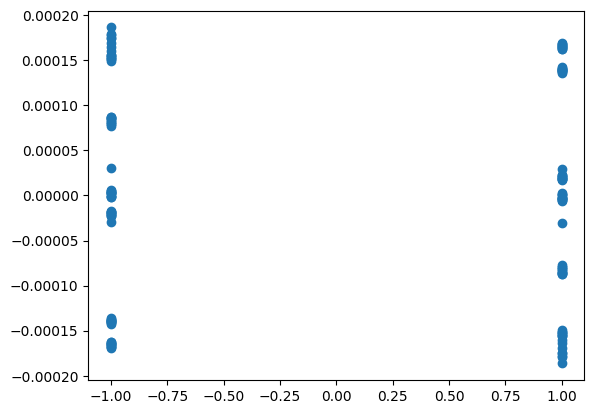

In [104]:
plt.scatter(a2 @ V[[0]].T, a2 @ V[[1]].T)

#### 3d stuff

In [105]:
full_a = einops.einsum(a, irrep, 'neuron d1, G d1 d2 -> neuron G d2').flatten(0, 1)
full_d = einops.einsum(d, irrep, 'neuron d1, G d1 d2 -> neuron G d2').flatten(0, 1)

In [106]:
import plotly.express as px
fig = px.scatter_3d(x=d[:,0].tolist(), y=d[:,1].tolist(), z=d[:,2].tolist())
fig.show()
# fig.write_html('/home/wilson/a.html')

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(a[:,0].tolist(), a[:,1].tolist(), a[:,2].tolist(), c='b', alpha=1.)
# ax.scatter(full_a[:,0].tolist(), full_a[:,1].tolist(), full_a[:,2].tolist(), c='b', alpha=0.1)
# plt.show()
# plt.scatter(d[:,0].tolist(), d[:,1].tolist())

In [155]:
a2 = t.concat([a, -a], dim=0)
U, S, V = t.linalg.svd(a2)

In [156]:
a.shape

torch.Size([121, 4])

In [93]:
# num_as=1
# ahat = t.concat(
#     [einops.repeat(a[i], 'd -> m d', m=a.shape[0]//num_as) for i in range(num_as-1)]
#     + [einops.repeat(a[num_as-1], 'd -> m d', m=a.shape[0]-(num_as-1) * (a.shape[0]//num_as))], 
#     dim=0
# )
# ahat = a[t.randperm(a.shape[0])]
# ahat = einops.repeat(b[1] - b[0], 'd -> m d', m=a.shape[0])
# ahat = ahat / ahat.norm(dim=-1).unsqueeze(-1)
ahat = a
Ahat = einops.einsum(ahat, b, 'm d1, m d2 -> m d1 d2')
Bhat = einops.einsum(c, ahat, 'm d1, m d2 -> m d1 d2')
ln = einops.einsum(irrep, Ahat.mT, 'G d1 d2, neuron d1 d2 -> G neuron') * A_norm
rn = einops.einsum(irrep, Bhat.mT, 'G d1 d2, neuron d1 d2 -> G neuron') * B_norm
Chat = einops.einsum(coef, Bhat @ Ahat, 'm, m d1 d2 -> m d1 d2')
un = einops.einsum(irrep, Chat.mT, 'G d1 d2, neuron d1 d2 -> G neuron') / (A_norm + B_norm) * 2

In [99]:
# losses = []
# for num_as in range(2, a.shape[0]):
#     ahat = t.concat(
#         [einops.repeat(a[i], 'd -> m d', m=a.shape[0]//num_as) for i in range(num_as-1)]
#         + [einops.repeat(a[num_as-1], 'd -> m d', m=a.shape[0]-(num_as-1) * (a.shape[0]//num_as))], 
#         dim=0
#     )
#     Ahat = einops.einsum(ahat, b, 'm d1, m d2 -> m d1 d2')
#     Bhat = einops.einsum(c, ahat, 'm d1, m d2 -> m d1 d2')
#     ln = einops.einsum(irrep, Ahat.mT, 'G d1 d2, neuron d1 d2 -> G neuron') * A_norm
#     rn = einops.einsum(irrep, Bhat.mT, 'G d1 d2, neuron d1 d2 -> G neuron') * B_norm
#     Chat = einops.einsum(coef, Bhat @ Ahat, 'm, m d1 d2 -> m d1 d2')
#     un = einops.einsum(irrep, Chat.mT, 'G d1 d2, neuron d1 d2 -> G neuron') / (A_norm + B_norm) * 2
#     losses.append(ablate_loss(t.concat([ln, other_lneurons], dim=-1), t.concat([rn, other_rneurons], dim=-1), t.concat([un, other_uneurons], dim=-1))['G0_loss'].item())

In [100]:
(ln - irrep_lneurons).norm()**2 / irrep_lneurons.norm()**2, (rn - irrep_rneurons).norm()**2 / irrep_rneurons.norm()**2, (un - irrep_uneurons).norm()**2 / irrep_uneurons.norm()**2

(tensor(1.4664), tensor(1.4686), tensor(0.0232))

In [94]:
other = [i for i in range(lneurons.shape[-1]) if i not in irrep_idxs]
other_lneurons, other_rneurons, other_uneurons= lneurons[:, other], rneurons[:, other], uneurons[:, other]
print(ablate_loss(other_lneurons, other_rneurons, other_uneurons), ablate_loss(irrep_lneurons, irrep_rneurons, irrep_uneurons))
print(ablate_loss(t.concat([irrep_lneurons, other_lneurons], dim=-1), t.concat([irrep_rneurons, other_rneurons], dim=-1), t.concat([irrep_uneurons, other_uneurons], dim=-1)))
print(ablate_loss(t.concat([ln, other_lneurons], dim=-1), t.concat([rn, other_rneurons], dim=-1), t.concat([un, other_uneurons], dim=-1)))
print(ablate_loss(ln, rn, un))

{'G0_loss': tensor([4.4469]), 'G0_acc': tensor([0.0087])} {'G0_loss': tensor([0.8187]), 'G0_acc': tensor([0.7269])}
{'G0_loss': tensor([0.0327]), 'G0_acc': tensor([1.])}
{'G0_loss': tensor([0.1025]), 'G0_acc': tensor([1.])}
{'G0_loss': tensor([0.1737]), 'G0_acc': tensor([1.])}


In [ ]:
# {'G0_loss': tensor([4.4466]), 'G0_acc': tensor([0.0083])} {'G0_loss': tensor([0.9043]), 'G0_acc': tensor([0.5908])}

In [64]:
other_lneurons.shape

torch.Size([120, 7])

In [65]:
(a.mean(dim=0) - d.mean(dim=0)).norm()**2 / a.mean(dim=0).norm()**2

tensor(1.9314e-05)

In [109]:
import plotly.express as px
import plotly.graph_objects as go
# Create the figure
fig = go.Figure()


fig = px.scatter_3d(
    x=b[:,0].tolist(), y=b[:,1].tolist(), z=b[:,2].tolist(), opacity=0.3, 
    # marker=dict(
    #     size=4,
    #     color='blue',
    #     opacity=0.3
    # ),
)
# fig = px.scatter_3d(
#     x=full_b[:,0].tolist(), y=full_b[:,1].tolist(), z=full_b[:,2].tolist(), opacity=0.03, 
#     marker=dict(
#         size=4,
#         color='blue',
#         opacity=0.3
#     ),
# )

# Add the second scatter plot (full_b) in red
# fig.add_trace(go.Scatter3d(
#     x=full_b[:,0].tolist(),
#     y=full_b[:,1].tolist(),
#     z=full_b[:,2].tolist(),
#     mode='markers',
#     marker=dict(
#         size=4,
#         color='red',
#         opacity=0.00,
#     ),
#     name='full_b'
# ))


# fig.add_trace(go.Scatter3d(
#     x=a2[:,0].tolist(),
#     y=a2[:,1].tolist(),
#     z=a2[:,2].tolist(),
#     mode='markers',
#     marker=dict(
#         size=6,
#         color='red',
#         opacity=.5,
#     ),
#     name='a'
# ))


# fig.add_trace(go.Scatter3d(
#     # x=full_b[:,0].tolist(),
#     # y=full_b[:,1].tolist(),
#     # z=full_b[:,2].tolist(),
#     x=bc_pair[:,0].tolist(),
#     y=bc_pair[:,1].tolist(),
#     z=bc_pair[:,3].tolist(),
#     mode='markers',
#     marker=dict(
#         size=6,
#         color='blue',
#         opacity=.5,
#     ),
#     name='b'
# ))



fig.show()
# fig.write_html('/home/wilson/ab.html')

In [67]:
A.shape

torch.Size([121, 4, 4])

In [68]:
rho = irrep[10]

trace_rho_A = einops.einsum(rho, A, 'd1 d2, m d2 d1 -> m')
trace_A = einops.einsum(A, 'm d1 d1 -> m')
list(zip(sorted(trace_rho_A.tolist()), sorted(trace_A.tolist())))

[(-0.7605388164520264, -0.7517490386962891),
 (-0.7564507126808167, -0.747555136680603),
 (-0.7527337074279785, -0.7391642332077026),
 (-0.7501431703567505, -0.7050055265426636),
 (-0.7494484782218933, -0.7049088478088379),
 (-0.7477362751960754, -0.6938212513923645),
 (-0.7458003759384155, -0.6931061744689941),
 (-0.7449398040771484, -0.6928953528404236),
 (-0.7448825240135193, -0.6925239562988281),
 (-0.7396479845046997, -0.6924957036972046),
 (-0.7380285859107971, -0.6911870241165161),
 (-0.7106956243515015, -0.6891772747039795),
 (-0.7045552730560303, -0.6849766969680786),
 (-0.7041484117507935, -0.6834962964057922),
 (-0.6977403163909912, -0.6787872910499573),
 (-0.6936909556388855, -0.6764672994613647),
 (-0.6933076977729797, -0.6731046438217163),
 (-0.6929901838302612, -0.6723490357398987),
 (-0.6929565072059631, -0.668040931224823),
 (-0.6925817728042603, -0.6598889827728271),
 (-0.6923143267631531, -0.6504643559455872),
 (-0.6914838552474976, -0.6501554250717163),
 (-0.6910746

### Plot $b_i$'s

In [222]:
full_b = einops.einsum(b, irrep, 'neuron d2, G d1 d2 -> neuron G d1').flatten(0, 1)
full_c = einops.einsum(c, irrep, 'neuron d2, G d1 d2 -> neuron G d1').flatten(0, 1)

0 1


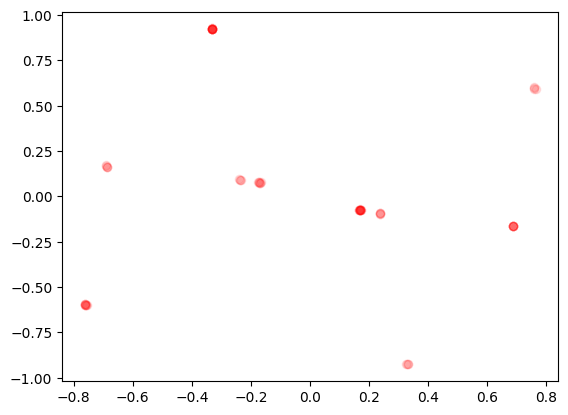

0 2


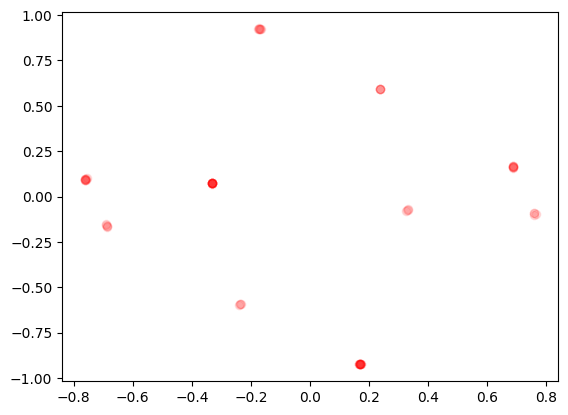

0 3


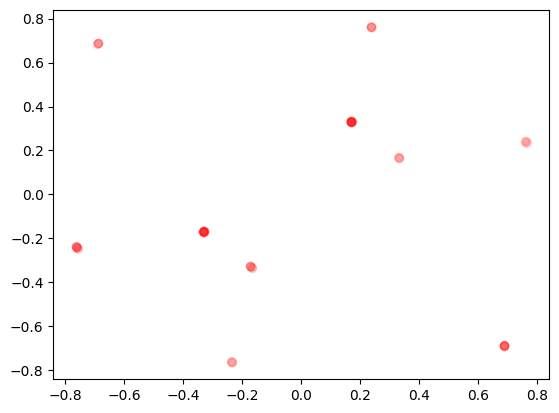

1 2


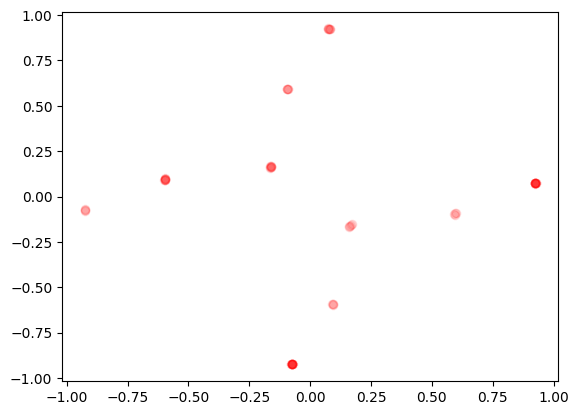

1 3


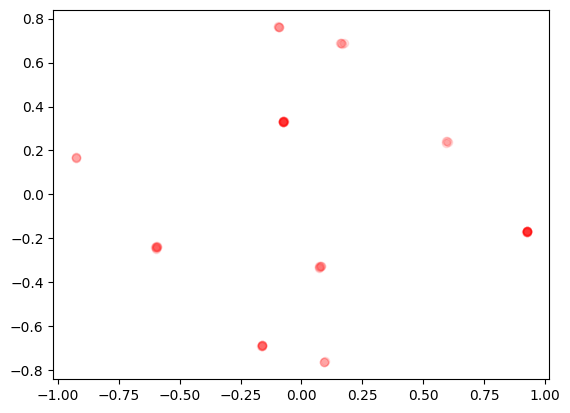

2 3


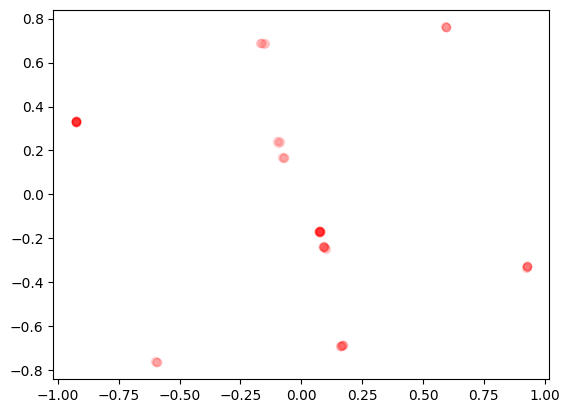

In [223]:
for i, j in list(product(range(irrep_d), repeat=2)):
    if i >= j:
        continue
    print(i, j)
    # plt.scatter(c[:,i].tolist(), c[:,j].tolist(), alpha=1., c='r')
    # plt.scatter(full_b[:,i].tolist(), full_b[:,j].tolist(), alpha=0.01, c='b')
    plt.scatter(b[:,i].tolist(), b[:,j].tolist(), alpha=.1, c='r')
    # plt.scatter(full_c[:,i].tolist(), full_c[:,j].tolist(), alpha=0.01, c='r')
    plt.show()

In [227]:
X = sum(max(0, t.dot(a[i], b[i] + c[i]).item()) * (c[i].unsqueeze(1) @ b[i].unsqueeze(1).T) for i in range(a.shape[0]))

In [229]:
X

tensor([[ 1.3264,  0.3489,  0.3925, -0.9783],
        [-0.0428,  1.3047, -0.5520,  0.2231],
        [-0.8919,  1.5203,  0.7868, -0.3573],
        [-0.2105, -1.2000, -0.2221,  1.1326]])

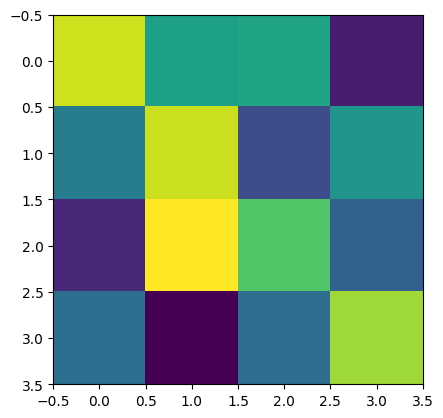

In [230]:
plt.imshow(X.numpy())
plt.show()

In [ ]:
axis1 = t.randn((irrep_d ,1))
axis2 = t.randn((irrep_d, 1))
plt.scatter(full_c @ axis1, full_c @ axis2, alpha=0.5)
plt.scatter(full_b @ axis1, full_b @ axis2, alpha=1.0)
plt.show()

### b_i and c_i are clustered

In [61]:
full_a = einops.einsum(a[[0]], irrep, 'neuron d1, G d1 d2 -> neuron G d2').flatten(0, 1)

In [62]:
((full_a @ a[[0]].T) > 0.95).sum()

tensor(1)

In [63]:
full_b = einops.einsum(b, irrep, 'neuron d1, G d1 d2 -> neuron G d2').flatten(0, 1)
full_c = einops.einsum(c, irrep, 'neuron d1, G d1 d2 -> neuron G d2').flatten(0, 1)

In [64]:
from sklearn.cluster import KMeans

def cluster(vecs, num_seeds=30, thresh=1, max=1000):
    n_clusters = 1
    losses = []
    while not losses or losses[-1] > thresh:
        n_clusters += 1
        kmeans = min(
            (KMeans(n_clusters=n_clusters, random_state=seed).fit(vecs.numpy())
            for seed in range(num_seeds)),
            key=lambda k: k.inertia_
        )
        losses.append(kmeans.inertia_)
        if len(losses) > 1 and losses[-2] / losses[-1] > 10:
            break
        if n_clusters >= max:
            break
        print(n_clusters, losses[-1])
    return kmeans, n_clusters, losses

In [65]:
b_kmeans, b_clusters, b_losses = cluster(full_b,) #max=10)
c_kmeans, c_clusters, c_losses = cluster(full_c,) #max=10)
b_labels, c_labels = b_kmeans.predict(b.numpy()), c_kmeans.predict(c.numpy())
b_mean, c_mean = b_kmeans.cluster_centers_, c_kmeans.cluster_centers_
b_clusters, c_clusters

2 14560.603515625
3 13309.58984375
4 12160.3798828125
5 10840.2412109375
6 9494.88671875
7 8185.908203125
8 6932.17333984375
9 5789.224609375
10 4579.06396484375
11 3761.78369140625
12 3388.331298828125
13 3089.863037109375
14 2716.4072265625
15 2342.953369140625
16 2041.68798828125
17 1668.235107421875
18 1361.0518798828125
19 1045.6927490234375
20 718.589599609375
21 373.7641296386719
2 14560.59375
3 13319.4609375
4 12154.6455078125
5 10840.23828125
6 9494.8798828125
7 8185.90771484375
8 6932.17333984375
9 5768.20166015625
10 4579.05224609375
11 3703.674560546875
12 3306.61328125
13 2933.22412109375
14 2639.77978515625
15 2342.935791015625
16 1969.4830322265625
17 1668.2117919921875
18 1419.1082763671875
19 1045.6507568359375
20 718.5516967773438
21 373.72039794921875


(22, 22)

In [112]:
t.tensor(b_mean[b_parts[0]]) @ a[[0]].T

tensor([[-0.3412],
        [ 0.7130],
        [-0.0011],
        [ 0.3421],
        [-0.7128]])

In [85]:
for i, j in product(range(b_clusters), range(c_clusters)):
    ij_mask = (b_labels == i) & (c_labels == j)
    if not ij_mask.any():
        continue
    print(i, j)
    print(ij_mask.nonzero())
    print('b dot c', np.dot(b_mean[i], c_mean[j]).item())
    print(a[ij_mask])
    print()

0 0
(array([ 0, 24, 57]),)
b dot c 0.24999824166297913
tensor([[ 0.4053,  0.5087, -0.7594, -0.0142],
        [ 0.6521, -0.6041,  0.4516, -0.0773],
        [ 0.5770,  0.4066, -0.7076, -0.0323]])

0 3
(array([50, 87]),)
b dot c 0.2499980628490448
tensor([[ 0.5512, -0.6386,  0.5324, -0.0698],
        [ 0.6673,  0.3376, -0.6625, -0.0429]])

0 7
(array([37, 78]),)
b dot c 0.24999822676181793
tensor([[ 0.6634, -0.5994,  0.4411, -0.0782],
        [ 0.4534,  0.4830, -0.7488, -0.0197]])

0 8
(array([61]),)
b dot c 0.2499983012676239
tensor([[ 0.3542,  0.5337, -0.7679, -0.0078]])

0 9
(array([34, 68]),)
b dot c -0.9999929070472717
tensor([[ 0.6558,  0.3469, -0.6692, -0.0419],
        [ 0.8246, -0.4968,  0.2564, -0.0872]])

1 1
(array([31]),)
b dot c 0.24999737739562988
tensor([[ 0.9517, -0.0792, -0.2850, -0.0820]])

1 2
(array([28, 46, 60, 70]),)
b dot c -0.9999895691871643
tensor([[ 0.8358, -0.4862,  0.2395, -0.0878],
        [ 0.6471,  0.3540, -0.6740, -0.0409],
        [ 0.9539, -0.0896, -0.2

In [84]:
bc_pair = t.stack([
    t.tensor(b_mean[i] + c_mean[j]) for i, j in product(b_parts[0], c_parts[0])
    if np.abs(np.dot(b_mean[i], c_mean[j])) < 0.5
], dim=0)
bc_pair = bc_pair / bc_pair.norm(dim=1).unsqueeze(1)
(a @ (bc_pair).T).abs().min(dim=1).values

tensor([0.1261, 0.0956, 0.0662, 0.0646, 0.0916, 0.0878, 0.1284, 0.1053, 0.1185,
        0.0830, 0.1767, 0.1664, 0.1590, 0.0704, 0.1717, 0.0849, 0.1483, 0.1508,
        0.1938, 0.1337, 0.0706, 0.1276, 0.1416, 0.1914, 0.1312, 0.1331, 0.1519,
        0.1260, 0.1704, 0.1467, 0.1413, 0.0761, 0.1739, 0.1585, 0.1111, 0.1607,
        0.1308, 0.1436, 0.1185, 0.0805, 0.1537, 0.1249, 0.0964, 0.1627, 0.1388,
        0.1550, 0.1431, 0.1497, 0.1547, 0.1461, 0.1437, 0.1036, 0.1465, 0.1027,
        0.0971, 0.0534, 0.1635, 0.0815, 0.0636, 0.1566, 0.1530, 0.1740, 0.1450,
        0.1588, 0.1914, 0.1432, 0.1332, 0.1449, 0.0419, 0.1260, 0.1226, 0.1213,
        0.1692, 0.1247, 0.1619, 0.0862, 0.0802, 0.1435, 0.1507, 0.0751, 0.1889,
        0.1447, 0.1050, 0.1386, 0.1027, 0.0877, 0.1192, 0.0730, 0.1753, 0.0787,
        0.0890, 0.0903, 0.1477, 0.1955, 0.1762, 0.1480, 0.0766, 0.1095, 0.0846,
        0.1540, 0.0428, 0.0925, 0.1606, 0.0724, 0.1390, 0.1123, 0.1173, 0.0768,
        0.1223, 0.1621, 0.0854, 0.1776, 

In [85]:
t.svd(bc_pair)[1]

tensor([2.2361, 2.2361, 2.2361, 2.2361])

In [83]:
t.svd(bc_pair)[1]

tensor([2.5197, 2.5025, 2.4898, 2.4878])

In [77]:
(a @ (bc_pair).T).shape

torch.Size([121, 25])

In [215]:
for i in range(b_clusters):
    print(f'b={i}')
    print(f'c={c_labels[b_labels==i].tolist()}')
    # print(f'coef={(coef[b_labels==i]*100).round().int().tolist()}')
    print()

b=0
c=[]

b=1
c=[]

b=2
c=[1, 1]

b=3
c=[]

b=4
c=[]

b=5
c=[]

b=6
c=[8, 8, 8, 8]

b=7
c=[]

b=8
c=[]

b=9
c=[]



In [111]:
b_parts = []
c_parts = []
for i in range(b_clusters):
    c_set = set(c_labels[b_labels == i].tolist())
    if not c_set:
        continue
    done = False
    for j in range(len(c_parts)):
        if len(c_set & c_parts[j]) > 0:
            c_parts[j] = c_set.union(c_parts[j])
            b_parts[j].add(i)
            done = True
            break
    if not done:
        c_parts.append(c_set)
        b_parts.append({i})
    print(f'b={i}, c={sorted(c_set)}')

# for b_part1, b_part2 in product(b_parts, repeat=2):
#     assert b_part1==b_part2 or not b_part1 & b_part2
# for c_part1, c_part2 in product(c_parts, repeat=2):
#     assert c_part1==c_part2 or not c_part1 & c_part2
b_parts = list(map(sorted, map(list, b_parts)))
c_parts = list(map(sorted, map(list, c_parts)))
print(b_parts)
print(c_parts)


b=0, c=[0, 6, 7, 8]
b=1, c=[1, 2, 3, 4, 5]
b=2, c=[1, 2, 3, 4, 5]
b=3, c=[1, 2, 3, 4, 5]
b=4, c=[1, 2, 3, 4, 5]
b=5, c=[1, 2, 3, 4, 5]
b=6, c=[0, 6, 7, 9]
b=7, c=[0, 6, 7, 8, 9]
b=8, c=[0, 6, 7, 8]
b=9, c=[0, 6, 7, 8, 9]
[[0, 6, 7, 8, 9], [1, 2, 3, 4, 5]]
[[0, 6, 7, 8, 9], [1, 2, 3, 4, 5]]


In [62]:
# Check that irrep is G-action on each partition of b's clusters
for b_part in b_parts:
    T = einops.einsum(b_mean[b_part], irrep, b_mean[b_part], 'm1 d1, G d1 d2, m2 d2 -> G m1 m2')
    T = (T > 0.95).astype(float)
    assert (T.sum(axis=1) == 1).all() and (T.sum(axis=2) == 1).all()

In [63]:
# Check that irrep is G-action on each partition of c's clusters
for c_part in c_parts:
    T = einops.einsum(c_mean[c_part], irrep, c_mean[c_part], 'm1 d1, G d1 d2, m2 d2 -> G m1 m2')
    T = (T > 0.95).astype(float)
    assert (T.sum(axis=1) == 1).all() and (T.sum(axis=2) == 1).all()

In [64]:
# Check that {b_i} = {-c_i} over all points
S = b_mean @ -c_mean.T
S = (S > 0.95).astype(float)
assert (S.sum(axis=0) == 1).all() and (S.sum(axis=1) == 1).all()

In [65]:
# Check that {b_i} = {-c_i} within each partition
for b_part, c_part in zip(b_parts, c_parts):
    # S = t.concat([b_mean[b_part], -b_mean[b_part]]) @ t.concat([-c_mean[c_part], c_mean[c_part]]).T
    S = b_mean[b_part] @ -c_mean[c_part].T
    S = (S > 0.95).astype(float)
    assert (S.sum(axis=0) == 1).all() and (S.sum(axis=1) == 1).all()

In [66]:
# Check that there are two partitions, and that they are antipodal
assert len(b_parts) == 2
T = b_mean[b_parts[0]] @ -b_mean[b_parts[1]].T
T = (T > 1 - 1e-2).astype(float)
assert (T.sum(axis=0) == 1).all() and (T.sum(axis=1) == 1).all()

In [67]:
# check that coefs are uniform over {b_i}x{c_i}
for b_part, c_part in zip(b_parts, c_parts):
    coef_sum = t.tensor([
        coef[(b_labels == i) & (c_labels == j)].sum().item()
        for i, j in product(b_part, c_part)
    ])
    print(f'size={coef_sum.norm()}, variance={(coef_sum - coef_sum.mean()).norm()**2/coef_sum.norm()**2}')
    print(coef_sum.tolist())

size=14.581692695617676, variance=0.041072290390729904
[2.9271507263183594, 3.0301852226257324, 2.947442054748535, 3.7306771278381348, 3.6133885383605957, 2.9927361011505127, 3.7859277725219727, 2.257120370864868, 2.655984401702881, 3.1560397148132324, 3.634443521499634, 2.2718491554260254, 2.205812692642212, 3.7508420944213867, 2.9436421394348145, 2.0772361755371094, 3.068580150604248, 2.210176467895508, 2.24330472946167, 1.8649656772613525, 3.2062294483184814, 3.5749683380126953, 2.653846025466919, 2.479753017425537, 2.113205909729004]
size=13.402325630187988, variance=0.05738019198179245
[2.6255760192871094, 2.7415590286254883, 1.6819978952407837, 1.9438964128494263, 2.556933641433716, 1.918022871017456, 3.153902530670166, 1.9036931991577148, 2.5628561973571777, 3.305253744125366, 3.5791714191436768, 3.5385055541992188, 1.5172001123428345, 3.618938446044922, 2.810096502304077, 2.682288646697998, 2.0427472591400146, 3.1616780757904053, 2.6220152378082275, 1.554329752922058, 2.3330056

In [185]:
coef_sum

tensor([2.6256, 1.6820, 1.9439, 2.5569, 2.7416, 1.9180, 1.9037, 2.5629, 3.3053,
        3.1539, 2.6823, 3.1617, 2.6220, 1.5543, 2.0427, 2.3330, 3.2394, 3.1658,
        1.8741, 2.9276, 3.5792, 1.5172, 3.6189, 2.8101, 3.5385])

### Activations are clustered

In [61]:
embedding_left = model.embedding_left.squeeze(0)
embedding_right = model.embedding_right.squeeze(0)
linear = model.linear.squeeze(0)
unembedding = model.unembedding.squeeze(0).T
# There's a degree of freedom with embedding/unembedding norm.
# Rescale so that each unembedding column is norm 1
u_norm = unembedding.norm(dim=0)
unembedding = unembedding / u_norm
linear = linear * u_norm

In [62]:
N = len(group)
inputs = t.tensor(list(product(range(N), repeat=2)), device=device)
l_in, r_in = inputs[..., 0], inputs[..., 1]
l_onehot = F.one_hot(l_in, num_classes=N).float()
r_onehot = F.one_hot(r_in, num_classes=N).float()
l_embed = einops.einsum(l_onehot, embedding_left, 'batch group, group embed -> batch embed')
r_embed = einops.einsum(r_onehot, embedding_right, 'batch group, group embed -> batch embed')
l_act = einops.einsum(l_embed, linear, 'batch embed, embed hid -> batch hid')
r_act = einops.einsum(r_embed, linear, 'batch embed, embed hid -> batch hid')
l_act = l_act[:, irrep_idxs]
r_act = r_act[:, irrep_idxs]
pre_act = l_act + r_act
act = t.maximum(t.zeros_like(l_act), l_act + r_act)
lin_logits = einops.einsum(pre_act, unembedding[:, irrep_idxs], 'batch hid, group hid-> batch group')
logits = einops.einsum(act, unembedding[:, irrep_idxs], 'batch hid, group hid-> batch group')

In [63]:
# 0, 24, 57 are same (i, j)
(act[:,0] - act[:,24]).norm()**2 / act[:,0].norm()**2

tensor(0.9876, grad_fn=<DivBackward0>)

In [64]:
act.shape

torch.Size([14400, 74])

In [65]:
logits.norm(), lin_logits.norm()

(tensor(5932.1118, grad_fn=<LinalgVectorNormBackward0>),
 tensor(459.0746, grad_fn=<LinalgVectorNormBackward0>))

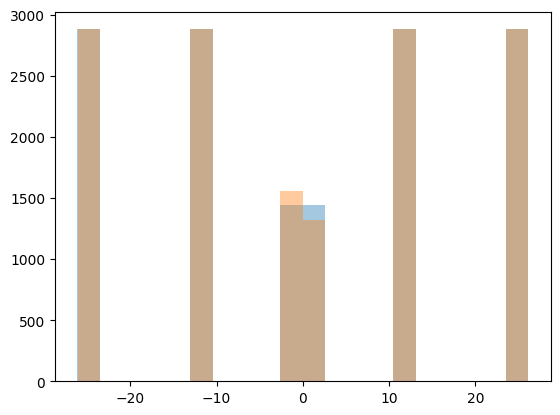

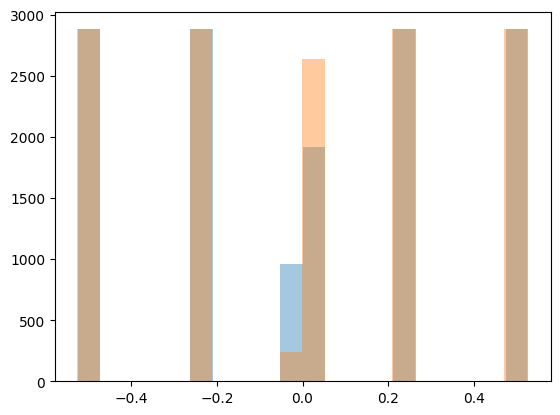

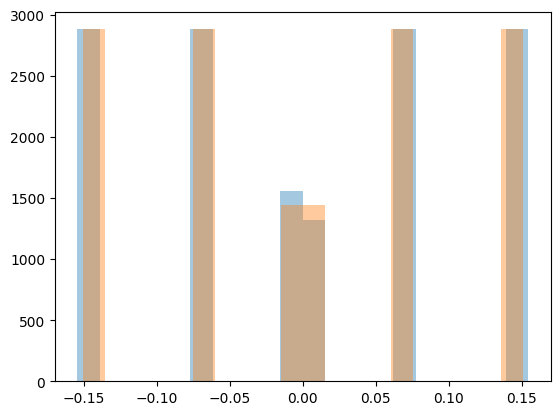

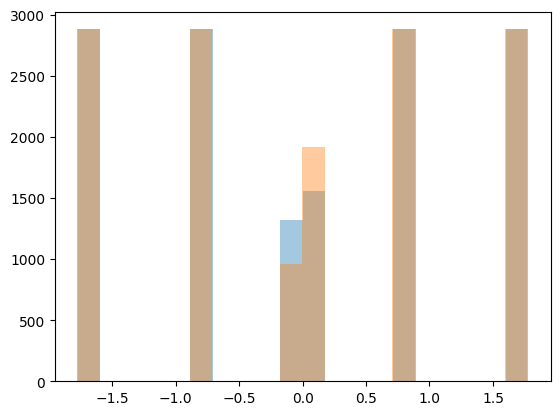

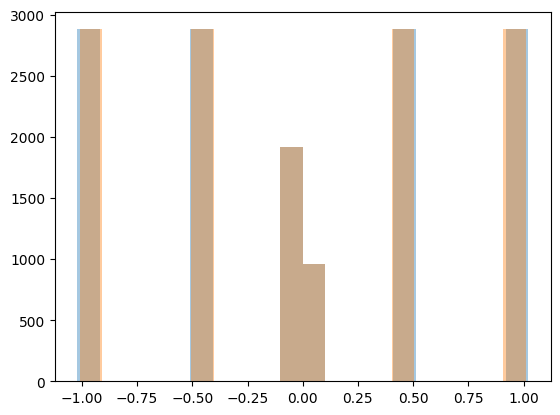

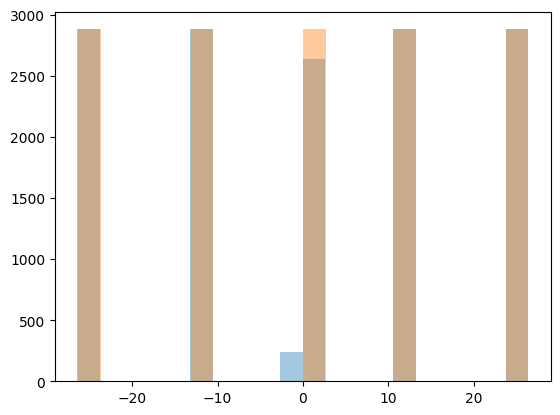

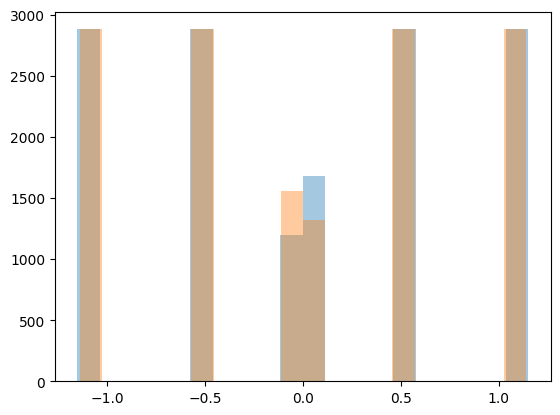

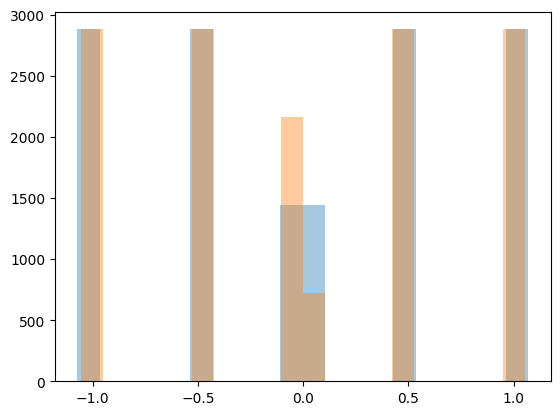

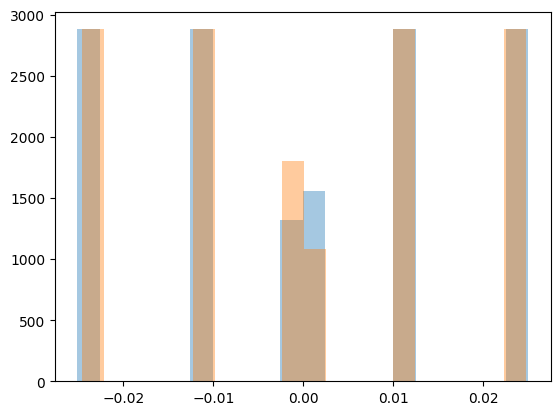

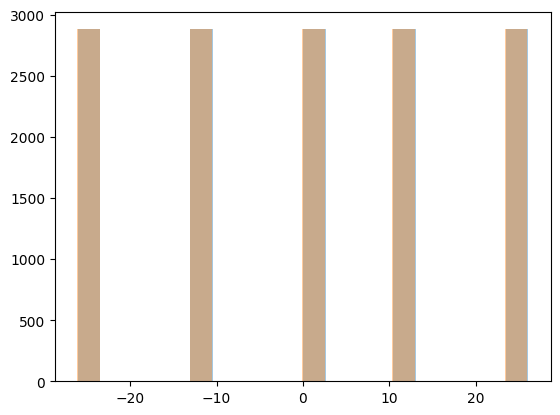

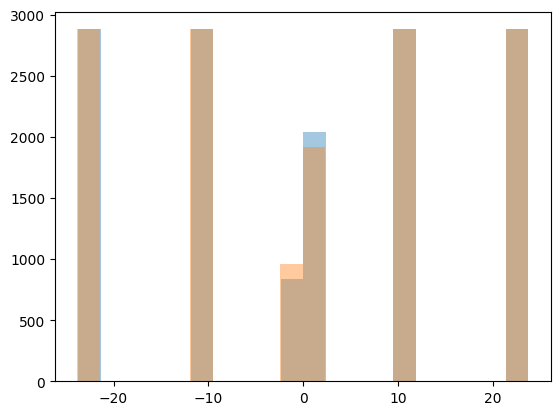

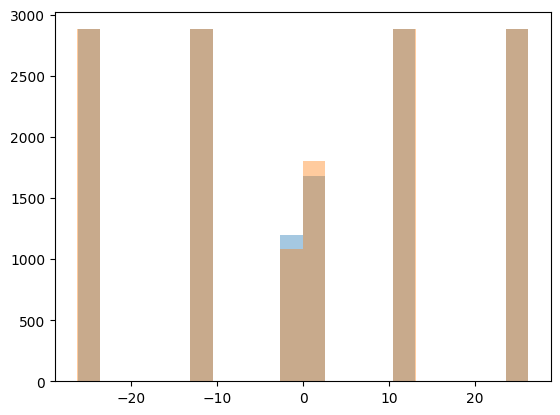

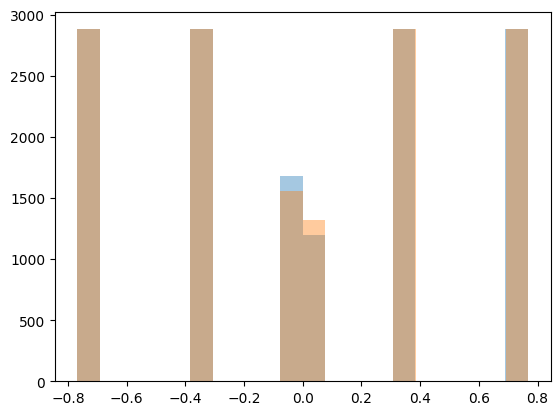

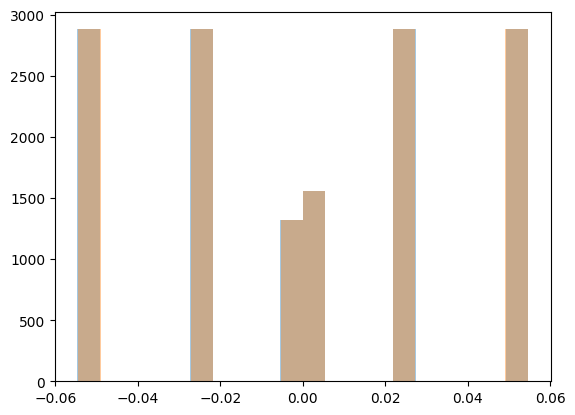

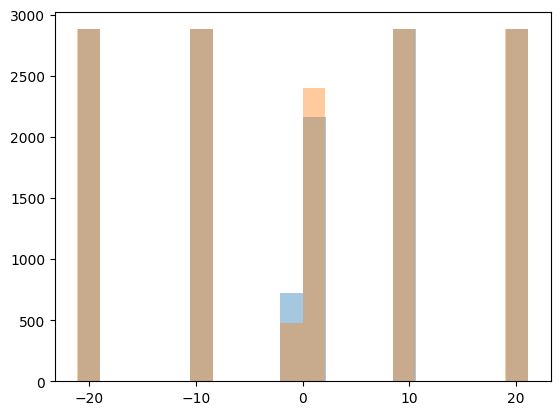

In [66]:
for i in range(15):
    plt.hist(l_act[:,i].tolist(), alpha=0.4, bins=20)
    plt.hist(r_act[:,i].tolist(), alpha=0.4, bins=20)
    plt.show()

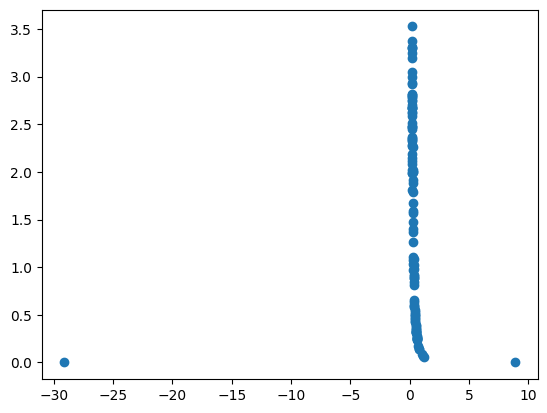

In [70]:
plt.scatter(coef.tolist(), l_act.max(dim=0)[0].tolist())
plt.show()

In [ ]:
big_neurons = (l_act.max(dim=0)[0] > 15).nonzero()

In [ ]:
b_part1

[0, 1, 3, 4, 9]

In [ ]:
b_labels[big_neurons]

array([[4],
       [5],
       [6],
       [2],
       [6],
       [4],
       [2],
       [6],
       [0],
       [0],
       [6],
       [2],
       [5],
       [5],
       [4],
       [4],
       [2],
       [4],
       [0],
       [5],
       [6],
       [0],
       [0]], dtype=int32)

In [ ]:
def ablate_loss(ln, rn, un):
    ablate_model = copy.deepcopy(model)
    ablate_model.linear.data = t.eye(ln.shape[1]).unsqueeze(0)
    ablate_model.embedding_left.data = ln.unsqueeze(0)
    ablate_model.embedding_right.data = rn.unsqueeze(0)
    ablate_model.unembedding.data = un.unsqueeze(0).mT
    return test_loss(ablate_model.to(device), data)

In [ ]:
big_mask = l_act.max(dim=0)[0] > 15
small_mask = l_act.max(dim=0)[0] < 3
part1_mask = t.tensor([i in b_part1 for i in b_labels], device=device)
part2_mask = t.tensor([i in b_part2 for i in b_labels], device=device)

In [ ]:
print(ablate_loss(irrep_lneurons, irrep_rneurons, irrep_uneurons))
print(ablate_loss(irrep_lneurons[:,big_mask], irrep_rneurons[:,big_mask], irrep_uneurons[:,big_mask]))
print(ablate_loss(irrep_lneurons[:,small_mask], irrep_rneurons[:,small_mask], irrep_uneurons[:,small_mask]))
print(ablate_loss(irrep_lneurons[:,part1_mask], irrep_rneurons[:,part1_mask], irrep_uneurons[:,part1_mask]))
print(ablate_loss(irrep_lneurons[:,part2_mask], irrep_rneurons[:,part2_mask], irrep_uneurons[:,part2_mask]))
print(ablate_loss(irrep_lneurons[:,part1_mask & big_mask], irrep_rneurons[:,part1_mask & big_mask], irrep_uneurons[:,part1_mask & big_mask]))
print(ablate_loss(irrep_lneurons[:,part1_mask & small_mask], irrep_rneurons[:,part1_mask & small_mask], irrep_uneurons[:,part1_mask & small_mask]))
print(ablate_loss(irrep_lneurons[:,part2_mask & big_mask], irrep_rneurons[:,part2_mask & big_mask], irrep_uneurons[:,part2_mask & big_mask]))
print(ablate_loss(irrep_lneurons[:,part2_mask & small_mask], irrep_rneurons[:,part2_mask & small_mask], irrep_uneurons[:,part2_mask & small_mask]))


{'G0_loss': tensor([0.8658]), 'G0_acc': tensor([0.5001])}
{'G0_loss': tensor([1.4867]), 'G0_acc': tensor([0.3433])}
{'G0_loss': tensor([4.2793]), 'G0_acc': tensor([0.3035])}
{'G0_loss': tensor([3.3410]), 'G0_acc': tensor([0.1060])}
{'G0_loss': tensor([2.6429]), 'G0_acc': tensor([0.1717])}
{'G0_loss': tensor([3.5448]), 'G0_acc': tensor([0.0409])}
{'G0_loss': tensor([4.5008]), 'G0_acc': tensor([0.0628])}
{'G0_loss': tensor([3.2302]), 'G0_acc': tensor([0.0570])}
{'G0_loss': tensor([4.5770]), 'G0_acc': tensor([0.0439])}


In [ ]:
ablate_loss(10*irrep_lneurons, 10*irrep_rneurons, 10*irrep_uneurons)

{'G0_loss': tensor([29.3090]), 'G0_acc': tensor([0.5001])}

In [ ]:
irrep_lneurons.shape

torch.Size([120, 52])

In [ ]:
big_mask.sum(), small_mask.sum() 

(tensor(23), tensor(25))